# Using GOMC to perform GEMC simulations of TraPPE Ethane

Computing vapor-liquid equilibrium (VLE) proeprties via molecular simulation often utilizes the 
Gibbs Ensemble Monte Carlo (GEMC) method. This workflow has several aims:

* Use mBuild to build compounds and pack boxes based on thermodynamic density (ethane in this example)
* Use foyer to parametrize compounds according to arbitrary force fields (TraPPE in this example)
* Use Python to systematically generate GOMC input files for performing GEMC simulations
* Run a GOMC simulation
* Use Python to quickly analyze GOMC output

In [1]:
import subprocess

import foyer
import mbuild as mb
import parmed
import unyt as u
from ethane.ethane import Ethane

# Ethane TraPPE Data

The following VLE data have been obtained from the [TraPPE website](http://chem-siepmann.oit.umn.edu/siepmann/trappe/index.html). 
We will be simulating VLE at 236 K.

Parametrization Data (1998):

| T (K) | $\rho_{vap}$ (g/ml) | $\rho_{liq}$ (g/ml) | $P_{vap}$ (kPa)|
------- |---------------------|----------------------|----------------|
| $178$ | $0.0022_{1}$ | $0.551_{1}$ | $105_{3}$ |
| $197$ | $0.0056_{5}$ | $0.527_{2}$ | $286_{25}$ |
| $217$ | $0.0100_{3}$ | $0.499_{1}$ | $541_{16}$ |
| $236$ | $0.020_{2}$ | $0.469_{2}$ | $1092_{75}$ |
| $256$ | $0.031_{4}$ | $0.432_{5}$ | $1740_{181}$ |
| $275$ | $0.056_{8}$ | $0.396_{5}$ | $2913_{254}$|

Validation Data (2017):

| T (K) | $\rho_{vap}$ (g/ml) | $\rho_{liq}$ (g/ml) | $P_{vap}$ (kPa)|
|------- |---------------------|----------------------|----------------|
| $178$ | $0.00233_{1}$ | $0.5511_{1}$ | $111.2_{4}$ |
| $197$ | $0.00541_{1}$ | $0.52643_{3}$ | $276.3_{6}$ |
| $212$ | $0.00942_{1}$ | $0.50573_{3}$ | $500.0_{4}$ |
| $236$ | $0.02019_{3}$ | $0.46940_{3}$ | $1102_{2}$ |
| $256$	| $0.0354_{1}$  | $0.43442_{5}$ | $1901_{2}$ |
| $275$ | $0.0599_{6}$	| $0.39405_{4}$ | $29951_{5}$ |
| $280$	| $0.0683_{4}$  | $0.3814_{1}$ | $3320_{10}$ |
| $285$ | $0.079_{1}$  | $0.3676_{1}$ | $3680_{10}$|
| $290$ | $0.093_{1}$ | $0.3524_{3}$ | $4080_{10}$|

Template ethane structures as well as the associated TraPPE parameters were downloaded from
the TraPPE website and can be found in the `./ethane` directory


### Citations
[1] M.G. Martin, and J.I. Siepmann,
Transferable potentials for phase equilibria. 1. United-atom description of n-alkanes
J. Phys. Chem. B 102, 2569-2577 (1998).

[2] M.S. Shah, M. Tsapatsis, and J.I. Siepmann,
Transferable potentials for phase equilibria. Improved united-atom description of ethane and ethylene
AIChE J. 63, 5098-5110 (2017).

# Using mBuild to construct our system

In this pure system, we only need to make utilize a single class for our `mb.Compound`.

We can specify the desired thermodynamic properties of our system; the densities will be used
to pack our box in a somewhat-realistic-configuration.

In [2]:
# This is our united-atom TraPPE ethane
cmpd = Ethane()
cmpd.name = "ETH"

# Thermodynamic statepoint
temperature = 236 * u.Kelvin
vapor_density = (
    0.020 * u.g / u.cm ** 3
)  # cm**3 = mL, but unyt doesn't support liter quantities
liquid_density = 0.469 * u.g / u.cm ** 3

vapor_density.convert_to_units(u.kg / u.m ** 3)  # convert to kg/m**3
liquid_density.convert_to_units(u.kg / u.m ** 3)

In [3]:
vapor_box = mb.fill_box(cmpd, n_compounds=100, density=vapor_density)
liquid_box = mb.fill_box(cmpd, n_compounds=100, density=liquid_density)

/Users/ayang41/Programs/mbuild/mbuild/packing.py:126: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  arg_count = 3 - [n_compounds, box, density].count(None)
/Users/ayang41/Programs/mbuild/mbuild/compound.py:2410: UserWarning: Guessing that "<CH3 pos=( 3.1151, 2.3298, 2.8438), 0 bonds, id: 4384894536>" is element: "C"
  atom, element))
/Users/ayang41/Programs/mbuild/mbuild/packing.py:126: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  arg_count = 3 - [n_compounds, box, density].count(None)


# Using foyer to atomtype and parametrize our system

Because this is a united-atom (UA) model, we need to re-name our particles to be consistent with
the custom-element, non-atomistic naming convetions within foyer by pre-pending
an underscore before every particle name.

We create a `foyer.Forcefield` object from our TraPPE XML file that contains force field parameters,
and then we can apply the force field to the two `mb.Compound` objects (vapor and liquid)

In [4]:
for particle in vapor_box.particles():
    particle.name = "_" + particle.name
for particle in liquid_box.particles():
    particle.name = "_" + particle.name
ff = foyer.Forcefield(forcefield_files="ethane/TraPPE_UA_2_fully_flexible_ethane.xml")
vapor_box_param = ff.apply(vapor_box, residues="ETH")
liquid_box_param = ff.apply(liquid_box, residues="ETH")

/Users/ayang41/Programs/foyer/foyer/forcefield.py:396: UserWarning: Non-atomistic element type detected. Creating custom element for _CH3
  'Creating custom element for {}'.format(element))
/Users/ayang41/Programs/mbuild/mbuild/compound.py:2410: UserWarning: Guessing that "<_CH3 pos=( 5.3538, 3.4600, 2.4862), 0 bonds, id: 4667602928>" is element: "EP"
  atom, element))
/Users/ayang41/anaconda3/envs/py36/lib/python3.6/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)
/Users/ayang41/Programs/mbuild/mbuild/compound.py:2410: UserWarning: Guessing that "<_CH3 pos=( 1.7601, 1.1401, 0.8984), 0 bonds, id: 4668700824>" is element: "EP"
  atom, element))
/Users/ayang41/anaconda3/envs/py36/lib/python3.6/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Ur

# Performing a GOMC simulation

We can put together some helper functions to help write out the relevant 
run-control files for GOMC. 
In particular, this input file requires information about temperature, box,
coordinates, topology, force field, and output.

GOMC utilizes CHARMM/NAMD-style PAR files for force field parameters, 
PDB files for coordinates and atom names, 
and PSF files for atom names, atom types, and topology

In [5]:
def write_gomc_gemc_input(
    filename,
    param_structure0,
    param_structure1,
    temperature=273,
    parameters="parameters.par",
    coords0="coords0.pdb",
    structure0="structure0.psf",
    coords1="coords1.pdb",
    structure1="structure1.psf",
    output="output",
):
    """Write GOMC input file for a GEMC simulation

    Some simulation input parameters have been hard-coded in accordance with the
    TraPPE specification.
    MC moves, CBMC parameters, and output control have been adapted from
    https://github.com/GOMC-WSU/GOMC_Examples/tree/master/NVT_GEMC/pure_fluid/octane_T_360_00_K
    Gibbs Ensemble Monte Carlo involves simultaneous simulations of
    two boxes (generally corresponding to two different phases)

    Parameters
    ----------
    filename : str
    param_structure0: parmed.Structure
        Should be parametrized
    param_structure1: parmed.Structure
        Should be parametrized
    temperature : float
        Implicitly in Kelvin
    parameters : str
        CHARMM/NAMD-style PAR file for force field information
    coords0 : str
        PDB file for param_structure0 coordinates and atom names
    structure0: str
        PSF file for param_structure0 atomtypes, bonding information, and topology
    coords1 : str
        PDB file for param_structure0 coordinates and atom names
    structure1: str
        PSF file for param_structure0 atomtypes, bonding information, and topology
    output : str
        Prefix for output files from simulation

    Notes
    -----
    Box dimensions are assumed to be orthorhombic
    GOMC input files utilize Angstroms, which are also the units of the parmed Structure box
    TraPPE uses 14 Angstrom cutoffs, but here we use 10 Angstrom because our simulations are small
    """
    with open(filename, "w") as f:
        f.write(
            """ 
###########################################################################
#  ========-------------------- INPUT --------------------------===========
############################################################################

#########################
# enable, step
#########################
Restart     false


####################################
# kind (RESTART, RANDOM, INTSEED)
####################################
PRNG        RANDOM

####################################
# FORCE FIELD
####################################
ParaTypeCHARMM   true
ParaTypeEXOTIC   false
Parameters      {parameters}

####################################
# INPUT PDB FILES
####################################
Coordinates 0    {coords0}
Coordinates 1    {coords1}

####################################
# INPUT PSF FILES
####################################
Structure 0      {structure0}
Structure 1      {structure1}



############################################################################
#  =======--------------------- SYSTEM --------------------------===========
############################################################################

##################################
# GEMC TYPE (DEFULT IS NVT_GEMC)
##################################
GEMC      NVT

#############################
# SIMULATION CONDITION
#############################
Temperature     {temperature}
Potential       VDW
LRC     true
Rcut        10
Exclude     1-4

#############################
# ELECTROSTATIC
#############################
ElectroStatic   false
Ewald           false

################################
# PRESSURE FREQ
################################
PressureCalc  true  1000

################################
# STEPS
################################
RunSteps           1000000
EqSteps        500000
AdjSteps       1000

################################
# MOVE FREQUENCY
################################
DisFreq               0.49
RotFreq           0.10
VolFreq           0.01
SwapFreq          0.20
RegrowthFreq          0.10
CrankShaftFreq        0.10

################################
# BOX DIMENSION #, X, Y, Z
################################
CellBasisVector1 0  {box0_x}  0.00    0.00
CellBasisVector2 0  0.00    {box0_y}  0.00
CellBasisVector3 0  0.00    0.00    {box0_z}

CellBasisVector1 1  {box1_x}  0.00    0.00
CellBasisVector2 1  0.00    {box1_y}  0.00
CellBasisVector3 1  0.00    0.00    {box1_z}


##############################
# CBMC TRIALS
##############################
CBMC_First   10
CBMC_Nth     8
CBMC_Ang     100
CBMC_Dih     30

####################################
#          Mol. Name     Chem. Pot.
####################################
############################################################################
#  =======-------------------- OUTPUT --------------------------===========
############################################################################

##########################
# statistics filename add
##########################
OutputName  {output}

#####################################
# enable, frequency
#####################################
CoordinatesFreq    true   1000000
RestartFreq        true   1000000
ConsoleFreq        true   100000
BlockAverageFreq   true   100000
HistogramFreq      false  100000


################################
# OutHistSettings
################################


##################################
# enable: blk avg., fluct.
##################################
OutEnergy         true    true
OutPressure       true    true
OutMolNum         true    true
OutDensity        true    true
""".format(
                temperature=temperature,
                parameters=parameters,
                structure0=structure0,
                coords0=coords0,
                structure1=structure1,
                coords1=coords1,
                box0_x=param_structure0.box[0],
                box0_y=param_structure0.box[1],
                box0_z=param_structure0.box[2],
                box1_x=param_structure1.box[0],
                box1_y=param_structure1.box[1],
                box1_z=param_structure1.box[2],
                output=output,
            )
        )

The PAR file that gets written is a generic PAR file for CHARMM/NAMD simulations. 
However, we need to post-process and modify the PAR file slightly for GOMC.

In [6]:
def modify_par_file(par_file):
    """GOMC parameter files do not use the atoms or impropers directive"""
    parlines = open(par_file).readlines()
    modified_parlines = open(par_file).readlines()
    found_atom_section = False
    to_delete = []
    for i, line in enumerate(parlines):
        if "ATOMS" in line:
            found_atom_section = True
            to_delete.append(i)
        elif found_atom_section:
            if "MASS" in line:
                to_delete.append(i)
            else:
                found_atom_section = False

        if "IMPROPERS" in line:
            modified_parlines[i] = "IMPROPER\n"
    to_delete.reverse()
    for delete_index in to_delete:
        modified_parlines.pop(delete_index)
    with open(par_file, "w") as f:
        for line in modified_parlines:
            f.write(line)

Now we can write out our Python objects to relevant input files

In [7]:
# Convert atomtypes to uppercase
for atom in vapor_box_param.atoms:
    atom.type = atom.type.upper()
    atom.atom_type.name = atom.atom_type.name.upper()
for atom in liquid_box_param.atoms:
    atom.type = atom.type.upper()
    atom.atom_type.name = atom.atom_type.name.upper()


# Save PDB and PSF files
vapor_box_param.save("coords0.pdb", overwrite=True, use_hetatoms=False)
vapor_box_param.save("structure0.psf", overwrite=True)
liquid_box_param.save("coords1.pdb", overwrite=True, use_hetatoms=False)
liquid_box_param.save("structure1.psf", overwrite=True)


# Prepare parmed Structure by converting to CharmmParameterSet
# We only need to generate one PAR file because both structures
# derive from the same force field parameters
paramset = parmed.charmm.CharmmParameterSet.from_structure(vapor_box_param)
paramset.write(par="parameters.par")

# Post-process PAR file
modify_par_file("parameters.par")

# Write GOMC run file, which requires box information and knowledge of other input files
write_gomc_gemc_input(
    "in.conf",
    vapor_box_param,
    liquid_box_param,
    temperature=temperature.value,
    parameters="parameters.par",
    coords0="coords0.pdb",
    structure0="structure0.psf",
    coords1="coords1.pdb",
    structure1="structure1.psf",
    output="output",
)

We use Python's `subprocess` module to make a shell command to run GOMC and capture output

In [8]:
p = subprocess.Popen(
    "GOMC_CPU_GEMC in.conf",
    shell=True,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    universal_newlines=True,
)
out, err = p.communicate()
with open("gomc.out", "w") as f:
    f.write(out)
with open("gomc.err", "w") as f:
    f.write(err)

# Analyzing a GOMC simulation

In [9]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

GOMC will dump block averages to whitespace-delimited DAT files, we can define a helper function
to convert the GOMC DAT file into a `pd.DataFrame` object to facilitate Python analysis

In [10]:
def dat_to_df(filename):
    """Convert GOMC DAT file to pandas DataFrame"""
    data = np.loadtxt(filename)
    columns = open(filename).readlines()[0]
    df = pd.DataFrame(data, columns=columns.split())
    return df

In [11]:
vapor_df = dat_to_df("Blk_output_BOX_0.dat")
liquid_df = dat_to_df("Blk_output_BOX_1.dat")

The resultant `pd.DataFrame` objects can be inspected

In [12]:
vapor_df

,#STEPS,TOT_EN,EN_INTER,EN_TC,EN_INTRA(B),EN_INTRA(NB),EN_ELECT,EN_REAL,EN_RECIP,TOTAL_VIR,PRESSURE,TOT_MOL,TOT_DENS,HEAT_VAP
0,100000.0,-8888.85213,-8417.01116,-471.978738,1.377662e-01,0.0,0.0,0.0,0.0,93151.59270,38.196433,100.87976,25.490860,11.160863
1,200000.0,-7018.59106,-6657.31275,-361.278306,-6.396814e-12,0.0,0.0,0.0,0.0,-12705.94840,11.610692,87.87823,22.358201,11.114211
2,300000.0,-7311.71590,-6931.48405,-380.231856,-6.396814e-12,0.0,0.0,0.0,0.0,-9650.55820,12.722484,90.37176,22.961079,11.217474
3,400000.0,-8008.49341,-7599.87339,-408.620021,-6.396814e-12,0.0,0.0,0.0,0.0,-11188.43620,12.912441,93.83706,23.791903,11.225183
4,500000.0,-6647.88087,-6297.48367,-350.397192,-6.396814e-12,0.0,0.0,0.0,0.0,-11140.19400,11.782348,86.63145,22.063380,11.140380
5,600000.0,-6660.84211,-6325.18925,-335.652865,-6.396814e-12,0.0,0.0,0.0,0.0,-11584.49600,11.323609,84.43487,21.525615,11.085658
6,700000.0,-5250.77864,-4983.98597,-266.792663,-6.396814e-12,0.0,0.0,0.0,0.0,-7879.83238,10.694901,75.02446,19.243158,11.068967
7,800000.0,-7162.56393,-6791.09310,-371.470835,-6.396814e-12,0.0,0.0,0.0,0.0,-9860.42938,12.497840,89.25787,22.696578,11.164795
8,900000.0,-6619.77673,-6279.72890,-340.047829,-6.396814e-12,0.0,0.0,0.0,0.0,-9614.86151,11.907234,85.17662,21.707148,11.167870
9,1000000.0,-6985.07789,-6641.97236,-343.105524,-6.396814e-12,0.0,0.0,0.0,0.0,-9957.90742,11.900711,85.60443,21.823018,11.036410


In [13]:
liquid_df

,#STEPS,TOT_EN,EN_INTER,EN_TC,EN_INTRA(B),EN_INTRA(NB),EN_ELECT,EN_REAL,EN_RECIP,TOTAL_VIR,PRESSURE,TOT_MOL,TOT_DENS,HEAT_VAP
0,100000.0,-99719.0872,-91055.6571,-8663.50496,7.488316e-02,0.0,0.0,0.0,0.0,1.413667e+06,7350.036950,99.12024,477.376761,11.160863
1,200000.0,-138728.1730,-128952.0030,-9776.17016,2.413535e-12,0.0,0.0,0.0,0.0,-7.978623e+04,0.667682,112.12177,477.051926,11.114211
2,300000.0,-135895.5220,-126305.3830,-9590.13957,2.413535e-12,0.0,0.0,0.0,0.0,-6.276371e+04,60.793969,109.62824,478.546492,11.217474
3,400000.0,-132571.3270,-123232.5430,-9338.78415,2.413535e-12,0.0,0.0,0.0,0.0,-7.119021e+04,17.438032,106.16294,481.208327,11.225183
4,500000.0,-139964.8630,-130087.7240,-9877.13913,2.413535e-12,0.0,0.0,0.0,0.0,-6.701841e+04,52.036938,113.36855,476.040536,11.140380
5,600000.0,-141986.8080,-131982.3010,-10004.50670,2.413535e-12,0.0,0.0,0.0,0.0,-8.593323e+04,-15.357844,115.56513,474.150327,11.085658
6,700000.0,-150928.7930,-140245.7830,-10683.00970,2.413535e-12,0.0,0.0,0.0,0.0,-9.263561e+04,-13.978126,124.97554,467.597232,11.068967
7,800000.0,-136591.6900,-126946.4060,-9645.28488,2.413535e-12,0.0,0.0,0.0,0.0,-8.047103e+04,-7.644132,110.74213,476.614996,11.164795
8,900000.0,-141423.2480,-131445.6940,-9977.55359,2.413535e-12,0.0,0.0,0.0,0.0,-7.794246e+04,12.422833,114.82338,475.286352,11.167870
9,1000000.0,-139719.7590,-129858.5180,-9861.24144,2.413535e-12,0.0,0.0,0.0,0.0,-7.641838e+04,18.261989,114.39557,471.483266,11.036410


We will plot simulation progress over time, and compare to the reference TraPPE VLE data

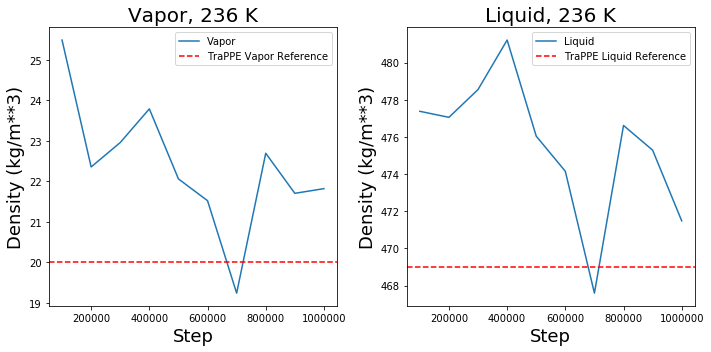

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title(f"Vapor, {temperature}", fontsize=20)
ax[0].plot(vapor_df["#STEPS"], vapor_df["TOT_DENS"], label="Vapor")
ax[0].axhline(
    vapor_density, label="TraPPE Vapor Reference", color="red", linestyle="--"
)
ax[0].set_ylabel("Density (kg/m**3)", fontsize=18)
ax[0].set_xlabel("Step", fontsize=18)

ax[1].set_title(f"Liquid, {temperature}", fontsize=20)
ax[1].plot(liquid_df["#STEPS"], liquid_df["TOT_DENS"], label="Liquid")
ax[1].axhline(
    liquid_density, label="TraPPE Liquid Reference", color="red", linestyle="--"
)
ax[1].set_ylabel("Density (kg/m**3)", fontsize=18)
ax[1].set_xlabel("Step", fontsize=18)

ax[0].legend()
ax[1].legend()

fig.tight_layout()

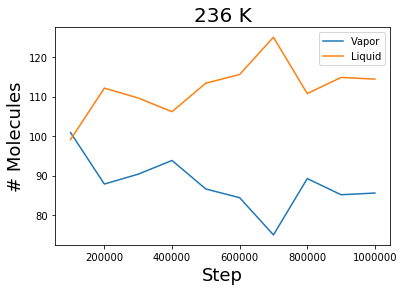

In [15]:
fig, ax = plt.subplots(1, 1)
ax.plot(vapor_df["#STEPS"], vapor_df["TOT_MOL"], label="Vapor")
ax.plot(liquid_df["#STEPS"], liquid_df["TOT_MOL"], label="Liquid")
ax.set_title(temperature, fontsize=20)
ax.set_ylabel("# Molecules", fontsize=18)
ax.set_xlabel("Step", fontsize=18)
ax.legend()

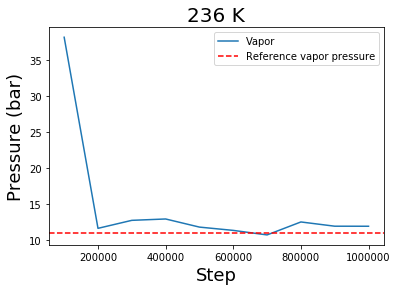

In [16]:
fig, ax = plt.subplots(1, 1)
ax.plot(vapor_df["#STEPS"], vapor_df["PRESSURE"], label="Vapor")
ref_pressure = 1092 * u.kilopascal
ref_pressure.convert_to_units(u.bar)
ax.axhline(
    ref_pressure.value, label="Reference vapor pressure", color="red", linestyle="--"
)
ax.set_title(temperature, fontsize=20)
ax.set_ylabel("Pressure (bar)", fontsize=18)
ax.set_xlabel("Step", fontsize=18)
ax.legend()

# Concluding Remarks

We have performed a GEMC simulation in GOMC using a variety of Python libraries to help organize and simplify our work. The routines should serve as a good example for reproducibly and extensibly building your own GOMC workflows. Utilizing workflow managers (on top of these modular Python routines) for large-scale virtual screening is left as an exercise to the reader.